In [1]:
import numpy as np
import xarray as xr
from datetime import datetime
import cftime
import matplotlib.pyplot as plt
from climatetranslation.unit.data import (
    get_dataset, 
    dataset_time_overlap, 
    any_calendar_to_datetime,
    construct_regridders,
    even_lat_lon,
    get_land_mask,
    precip_kilograms_to_mm
)

from climatetranslation.unit.translate import (
    network_translate_constructor,
    get_data_transformer
)
from climatetranslation.unit.utils import get_config

from dask.diagnostics import ProgressBar
import cartopy.crs as ccrs

In [2]:
conf = get_config("/home/dfulu/model_outputs/outputs/hadgem3_to_era5_monsoon/config.yaml")

In [3]:
conf['level_vars']

{0: ['pr'], 2: ['tas', 'tasmin', 'tasmax'], 5500: ['z500']}

In [4]:
conf

{'image_save_iter': 8000,
 'image_display_iter': 1000,
 'display_size': 16,
 'snapshot_save_iter': 2000,
 'log_iter': 100,
 'max_iter': 1000000,
 'batch_size': 1,
 'weight_decay': 0.0001,
 'beta1': 0.5,
 'beta2': 0.999,
 'init': 'kaiming',
 'lr': 0.0001,
 'lr_policy': 'step',
 'step_size': 100000,
 'gamma': 0.5,
 'gan_w': 16,
 'recon_x_w': 10,
 'recon_kl_w': 0.01,
 'recon_x_cyc_w': 10,
 'recon_kl_cyc_w': 0.01,
 'vgg_w': 0,
 'recon_loss_func': 'mae',
 'gen': {'dim': 64,
  'mlp_dim': 256,
  'style_dim': 8,
  'activ': 'lrelu',
  'n_downsample': 2,
  'n_res': 4,
  'pad_type': 'zero',
  'upsample': 'conv',
  'output_activ': ['relu', 'none', '-relu', 'relu', 'none']},
 'dis': {'dim': 64,
  'norm': 'none',
  'activ': 'lrelu',
  'n_layer': 4,
  'gan_type': 'lsgan',
  'num_scales': 3,
  'pad_type': 'zero'},
 'num_workers': 5,
 'data_zarr_a': '/datadrive/era5/all_hist_global_zarr',
 'data_zarr_b': '/datadrive/hadgem3/all_hist_zarr',
 'agg_data_a': '/datadrive/era5/monsoon_all_hist_hadgem3_agg.nc

In [5]:
def select_months(da, months, drop=False):
    in_months = xr.DataArray(np.isin(da['time.month'], months), coords=[da.time])
    return da.where(in_months, drop=drop)

def common_min_max(das):
    vmin = min([da.min() for da in das])
    vmax = max([da.max() for da in das])
    return vmin, vmax

In [6]:
conf_levels = conf['level_vars']
bbox = conf['bbox']

In [7]:
model = 'era5'
other_model = ({'era5','hadgem3'} - {model}).pop()

In [8]:
ds_target = get_dataset(f"/datadrive/{model}/all_hist{'_global' if model=='era5' else ''}_zarr", 
                      conf_levels, 
                      filter_bounds=False,
                      split_at=360, 
                      bbox=bbox)
ds_base = get_dataset(f"/datadrive/{other_model}/all_hist{'_global' if other_model=='era5' else ''}_zarr", 
                      conf_levels, 
                      filter_bounds=False,
                      split_at=360, 
                      bbox=bbox)
ds_trans = get_dataset(f"/datadrive/{other_model}/monsoon_to_{model}_zarr", 
                       conf_levels, 
                       filter_bounds=False, 
                       split_at=360, 
                       bbox=bbox)
ds_trans_reverse = get_dataset(f"/datadrive/{model}/monsoon_to_{other_model}_zarr", 
                       conf_levels, 
                       filter_bounds=False, 
                       split_at=360, 
                       bbox=bbox)
ds_qm = get_dataset(f"/datadrive/{other_model}/all_hist{'_global' if other_model=='era5' else ''}_qm_to_{model[:3]}_zarr",
                       conf_levels, 
                       filter_bounds=False, 
                       split_at=360, 
                       bbox=bbox)
ds_qm_reverse = get_dataset(f"/datadrive/{model}/all_hist{'_global' if model=='era5' else ''}_qm_to_{other_model[:3]}_zarr",
                       conf_levels, 
                       filter_bounds=False, 
                       split_at=360, 
                       bbox=bbox)


rg_t, rg_b = construct_regridders(
    ds_target, 
    ds_base, 
    resolution_match='downscale', 
    scale_method='conservative', 
    periodic=False)

if rg_t is not None:
    ds_target = rg_t(ds_target)
if rg_b is not None:
    ds_base = rg_b(ds_base)
    
if conf['time_range'] is not None:
    if conf['time_range'] == 'overlap':
        ds_target, ds_base, ds_trans, ds_trans_reverse, ds_qm, ds_qm_reverse = dataset_time_overlap([ds_target, ds_base, ds_trans,ds_trans_reverse, ds_qm, ds_qm_reverse])
    elif isinstance(conf['time_range'], dict):
        time_slice = slice(conf['time_range']['start_date'], conf['time_range']['end_date'])
        ds_target, ds_base, ds_trans, ds_trans_reverse, ds_qm, ds_qm_reverse = [ds.sel(time=time_slice) for ds in [ds_target, ds_base, ds_trans, ds_trans_reverse, ds_qm, ds_qm_reverse]]
    else:
        raise ValueError("time_range not valid : {}".format(conf['time_range']))

{'N': 30, 'S': -8, 'E': 121, 'W': 44}
{'N': 30, 'S': -8, 'E': 121, 'W': 44}
{'N': 30, 'S': -8, 'E': 121, 'W': 44}
{'N': 30, 'S': -8, 'E': 121, 'W': 44}
{'N': 30, 'S': -8, 'E': 121, 'W': 44}
{'N': 30, 'S': -8, 'E': 121, 'W': 44}
Create weight file: conservative_76x154_68x92.nc
Remove file conservative_76x154_68x92.nc
using dimensions ('lat', 'lon') from data variable pr as the horizontal dimensions for this dataset.
start time (1979-01-01T12:00:00) and end time (2013-12-30T00:00:00)


In [9]:
for ds in [ds_target, ds_base, ds_trans, ds_trans_reverse, ds_qm, ds_qm_reverse]:
    precip_kilograms_to_mm(ds)

In [10]:
from skimage.metrics import structural_similarity as ssim

def calc_range(das):
    vmin, vmax = common_min_max(das)
    return (vmax - vmin).values

def find_closest(da_ref, da_search, use_ssim=True):
    if use_ssim:
        r = calc_range([da_search, da_ref])
        s = ssim(
            np.tile(da_ref.values,(len(da_search.time),1,1)), 
            da_search.values, 
            data_range=r, 
            full=True
        )[1].mean(axis=(-1,-2))
        n = s.argmax()
    else:
        s  = ((np.tile(da_ref.values,(len(da_search.time),1,1)) - da_search.values)**2).mean(axis=(-1,-2))
        n = s.argmin()
    return n, da_search.isel(time=n)

find_closest(ds_base.pr.isel(time=slice(233,234), run=0), ds_base.pr.isel(run=0, time=slice(0, 1000)), use_ssim=0)

(233, <xarray.DataArray 'pr' (lat: 68, lon: 92)>
 dask.array<getitem, shape=(68, 92), dtype=float32, chunksize=(68, 92), chunktype=numpy.ndarray>
 Coordinates:
     time     object 1979-08-24 12:00:00
     run      int64 1
   * lon      (lon) float32 44.583332 45.416664 46.25 ... 119.58333 120.416664
   * lat      (lat) float32 -7.499997 -6.9444413 ... 29.166672 29.722227)

In [11]:
ds_target.pr.load()
ds_base.pr.load()
ds_trans.pr.load()
ds_trans_reverse.pr.load()
ds_qm.pr.load()
ds_qm_reverse.pr.load()

<xarray.DataArray 'pr' (run: 1, time: 12782, lat: 68, lon: 92)>
array([[[[1.78910389e+01, 2.14653625e+01, 2.63754520e+01, ...,
          4.66111869e-01, 5.84600687e-01, 1.21546793e+00],
         [1.64309654e+01, 1.74153728e+01, 2.13857517e+01, ...,
          2.87316561e-01, 8.35026622e-01, 1.76949894e+00],
         [1.18287764e+01, 1.58468227e+01, 1.96545429e+01, ...,
          1.82842755e+00, 1.31214416e+00, 9.11545038e-01],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          2.86932325e+00, 2.52189255e+00, 4.73780298e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          4.83003473e+00, 3.72249579e+00, 4.48620224e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          6.04807615e+00, 5.69818735e+00, 5.92592716e+00]],

        [[9.42312121e-01, 3.05468273e+00, 1.45797825e+01, ...,
          8.68312597e-01, 1.78730881e+00, 3.15385652e+00],
         [3.62566143e-01, 1.47316289e+00, 9.32264900e+00, ...,
          4.79517013e-01, 1.08492982e+00, 2.53502798e+00],
         [5.97956181e-02, 3.83106738e-01, 3.08597398e+00, ...,
          6.01118386e-01, 6.04816914e-01, 2.96747863e-01],
...
          2.22717635e-02, 1.50201712e-02, 1.95715316e-02],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          2.42753085e-02, 1.74425524e-02, 1.35551458e-02],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          2.03303173e-02, 1.57104041e-02, 9.78868082e-03]],

        [[4.91381019e-01, 6.67254508e-01, 1.69102073e+00, ...,
          9.26154041e+00, 5.36779070e+00, 4.83877420e+00],
         [1.77144063e+00, 2.42451644e+00, 4.04270744e+00, ...,
          1.08674831e+01, 4.64052534e+00, 1.71550798e+00],
         [2.64587235e+00, 3.70927787e+00, 5.12625980e+00, ...,
          1.36823626e+01, 2.26733661e+00, 2.88232177e-01],
         ...,
         [3.90301079e-01, 5.96328862e-02, 1.10441744e-02, ...,
          2.22717635e-02, 1.50201712e-02, 1.95715316e-02],
         [1.42809302e-01, 6.51242211e-03, 2.24810536e-03, ...,
          2.42753085e-02, 1.74425524e-02, 1.35551458e-02],
         [6.56833723e-02, 6.19761087e-03, 2.03549760e-04, ...,
          2.03303173e-02, 1.57104041e-02, 9.78868082e-03]]]],
      dtype=float32)
Coordinates:
  * lon      (lon) float64 44.58 45.42 46.25 47.08 ... 117.9 118.8 119.6 120.4
  * time     (time) datetime64[ns] 1979-01-02 1979-01-03 ... 2013-12-30
  * run      (run) int64 1
  * lat      (lat) float32 -7.499997 -6.9444413 ... 29.166672 29.722227

In [12]:
ds_target.z500.load()
ds_base.z500.load()
ds_trans.z500.load()
ds_trans_reverse.z500.load()
ds_qm.z500.load()
ds_qm_reverse.z500.load()

<xarray.DataArray 'z500' (run: 1, time: 12782, lat: 68, lon: 92)>
array([[[[5834.225 , 5833.7188, 5833.3984, ..., 5838.7695, 5838.8813,
          5838.9443],
         [5833.932 , 5833.838 , 5833.908 , ..., 5838.6177, 5839.0254,
          5839.222 ],
         [5834.102 , 5834.3164, 5834.2856, ..., 5838.879 , 5839.3325,
          5839.2437],
         ...,
         [5758.6724, 5758.4346, 5758.151 , ..., 5675.975 , 5679.4834,
          5682.5273],
         [5754.9556, 5754.263 , 5754.144 , ..., 5665.855 , 5669.096 ,
          5672.7734],
         [5750.488 , 5751.183 , 5751.7007, ..., 5656.62  , 5659.86  ,
          5662.7256]],

        [[5840.843 , 5840.5767, 5840.3545, ..., 5840.997 , 5839.9116,
          5838.6675],
         [5841.066 , 5840.713 , 5840.4473, ..., 5841.395 , 5840.3647,
          5839.311 ],
         [5840.8623, 5840.826 , 5840.517 , ..., 5841.6426, 5840.6514,
          5839.4863],
...
         [5737.7324, 5739.43  , 5739.106 , ..., 5654.218 , 5653.018 ,
          5652.328 ],
         [5732.997 , 5734.318 , 5735.61  , ..., 5642.825 , 5641.7188,
          5640.0654],
         [5727.318 , 5729.1875, 5730.6055, ..., 5633.1006, 5633.979 ,
          5631.248 ]],

        [[5847.2515, 5846.9946, 5846.971 , ..., 5854.6655, 5855.023 ,
          5855.279 ],
         [5847.4917, 5847.433 , 5847.5396, ..., 5854.4146, 5854.409 ,
          5854.789 ],
         [5847.8286, 5847.678 , 5847.7437, ..., 5854.256 , 5854.2803,
          5854.351 ],
         ...,
         [5678.5176, 5686.5293, 5693.5273, ..., 5682.454 , 5681.723 ,
          5682.305 ],
         [5669.9995, 5677.317 , 5686.6436, ..., 5671.391 , 5671.0107,
          5671.425 ],
         [5660.0513, 5669.586 , 5681.704 , ..., 5659.6484, 5659.7046,
          5659.484 ]]]], dtype=float32)
Coordinates:
  * lon      (lon) float64 44.58 45.42 46.25 47.08 ... 117.9 118.8 119.6 120.4
  * time     (time) datetime64[ns] 1979-01-02 1979-01-03 ... 2013-12-30
  * run      (run) int64 1
  * lat      (lat) float32 -7.499997 -6.9444413 ... 29.166672 29.722227

"1983-08-11"

In [222]:
power=1#0.25
transform = lambda x : np.log10(1e-6+x)
vmin_override = -1.#None #-0.5
vmax_override  = None #40 #2

ds_target_pr = transform(ds_target.pr.isel(run=0).clip(0)**power)

In [237]:
samples = [transform(select_months(ds.pr.isel(run=0), [6, 7, 8, 9], drop=True).sel(time="1994-07-06").clip(0)**power) for ds in [ds_base, ds_trans, ds_qm]]
[s.time.values for s in samples]

[array([cftime.Datetime360Day(1994, 7, 6, 12, 0, 0, 0)], dtype=object),
 array([cftime.Datetime360Day(1994, 7, 6, 12, 0, 0, 0)], dtype=object),
 array([cftime.Datetime360Day(1994, 7, 6, 12, 0, 0, 0)], dtype=object)]

/anaconda/envs/py37_pytorch2/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


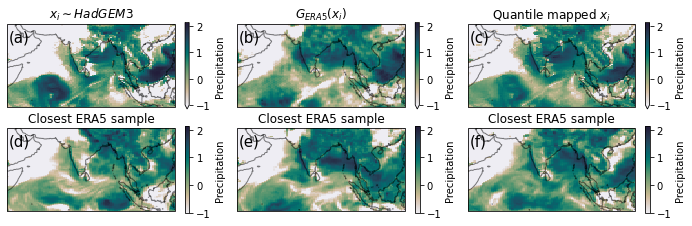

In [274]:
import cmocean
plt.figure(figsize=(12,3.5))
cmap=cmocean.cm.rain
#titles = ["HadGEM3", f"UNIT translated: HadGEM3 to ERA5", f"QM translated: HadGEM3 to ERA5"]
titles = [r'$x_i \sim HadGEM3$',
          r'$G_{ERA5}(x_i)$', 
          r'Quantile mapped $x_i$']
include_match_for_each=True



def range_multi(L):
    vmin = min([l.min() for l in L]).values
    vmax = max([l.max() for l in L]).values
    return vmin, vmax

vmin, vmax = range_multi(samples)
if vmin_override is not None:
    vmin = vmin_override
if vmax_override is not None:
    vmax = vmax_override

projection = ccrs.PlateCarree()
dlon = np.diff(samples[i].lon)[0]
lon_range = (samples[i].lon.min() - dlon/2, samples[i].lon.max() + dlon/2)

dlat = np.diff(samples[i].lon)[0]
lat_range = (samples[i].lat.min() - dlat/2, samples[i].lat.max() + dlat/2)

for i, (title, letters) in enumerate(zip(titles, ['ad', 'be', 'cf'])):
    ax1 = plt.subplot(231+i, projection=projection)
    
    cbar_kwargs = dict(label=f"Precipitation")# if i==2 else dict(label=f"")
    
    (samples[i]).plot(ax=ax1, vmin=vmin, vmax=vmax, cmap=cmap, cbar_kwargs=cbar_kwargs)
    
    
    
    if i==0 or include_match_for_each:
        ax2 = plt.subplot(234+i,projection=projection)
        find_closest(samples[i].clip(vmin, vmax), ds_target_pr.clip(vmin, vmax), use_ssim=True
                    )[1].plot(ax=ax2, vmin=vmin, vmax=vmax, cmap=cmap, cbar_kwargs=cbar_kwargs)
    
    ax1.set_title(title)
    ax1.text(45,22, f"({letters[0]})", {'fontsize':15})
    ax2.set_title('Closest ERA5 sample')
    ax2.text(45,22, f"({letters[1]})", {'fontsize':15})
                                     
    for ax in [ax1, ax2][:1+(i==0 or include_match_for_each)]:
        ax.set_xlim(*lon_range)
        ax.set_ylim(*lat_range)
        ax.coastlines(alpha=0.5)

plt.tight_layout()
plt.subplots_adjust(wspace=0.1)
plt.show()

In [242]:
lon_range, lat_range

((<xarray.DataArray 'lon' ()>
  array(44.16666603)
  Coordinates:
      run      int64 1, <xarray.DataArray 'lon' ()>
  array(120.83333015)
  Coordinates:
      run      int64 1), (<xarray.DataArray 'lat' ()>
  array(-7.91666317)
  Coordinates:
      run      int64 1, <xarray.DataArray 'lat' ()>
  array(30.13889313)
  Coordinates:
      run      int64 1))

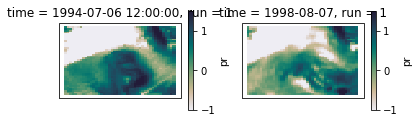

In [257]:
sel=dict(lon=slice(44, 80), lat=slice(-7, 15))

ax1 = plt.subplot(221, projection=projection)
ax2 = plt.subplot(222, projection=projection)

vmin, vmax = -1, 1.5

samples[2].clip(vmin, vmax).sel(**sel).plot(vmin=vmin, vmax=vmax, cmap=cmap, ax=ax1)
find_closest(samples[2].clip(vmin, vmax).sel(**sel), ds_target_pr.clip(vmin, vmax).sel(**sel), use_ssim=1)[1].plot(ax=ax2, vmin=vmin, vmax=vmax, cmap=cmap)

Try these dates for examples
- "1980-09-07"
- "1980-07-07"
- 1982-08-12
- 1989-06-12
- 1994-06-01

In [144]:
samples = [select_months(ds.pr.isel(run=0), [6, 7, 8, 9], drop=True).sel(time="1982-08-12") for ds in [ds_base, ds_target, ds_trans_reverse]]
[s.time.values for s in samples]

[array([cftime.Datetime360Day(1982, 8, 12, 12, 0, 0, 0)], dtype=object),
 numpy.datetime64('1982-08-12T00:00:00.000000000'),
 numpy.datetime64('1982-08-12T00:00:00.000000000')]

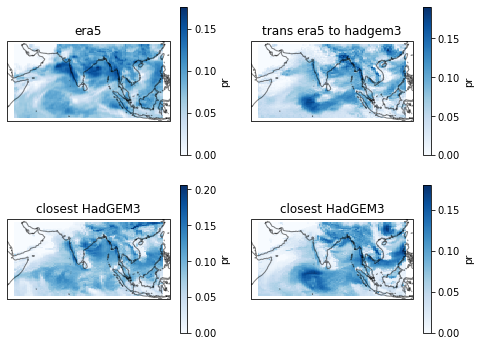

In [145]:
vmin, vmax = 0, None
plt.figure(figsize=(8,6))
titles = [model, f"trans {model} to {other_model}"]
cmap = 'Blues'

for i, title in enumerate(titles):
    ax1 = plt.subplot(221+i, projection=ccrs.PlateCarree())
    (samples[i+1].clip(0, None)**0.25).plot(ax=ax1, vmin=vmin, vmax=vmax, cmap=cmap)
    
    ax2 = plt.subplot(223+i, projection=ccrs.PlateCarree())
    find_closest(samples[i+1].clip(0, None)**0.25, ds_base.pr.isel(run=0).clip(0, None)**0.25, use_ssim=False)[1].plot(ax=ax2, vmin=vmin, vmax=vmax, cmap=cmap)
    
    ax1.coastlines(alpha=0.5)
    ax1.set_title(title)
    ax2.coastlines(alpha=0.5)
    ax2.set_title('closest HadGEM3')
    
plt.show()

In [152]:
samples = [select_months(ds.z500.isel(run=0), [6, 7, 8, 9], drop=True).sel(time="1982-08-12") for ds in [ds_base, ds_target, ds_trans_reverse]]
[s.time.values for s in samples]

[array([cftime.Datetime360Day(1982, 8, 12, 12, 0, 0, 0)], dtype=object),
 numpy.datetime64('1982-08-12T00:00:00.000000000'),
 numpy.datetime64('1982-08-12T00:00:00.000000000')]

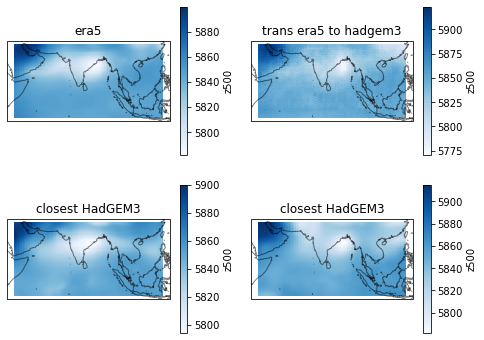

In [153]:
vmin, vmax = None, None
plt.figure(figsize=(8,6))
titles = [model, f"trans {model} to {other_model}"]
cmap = 'Blues'

for i, title in enumerate(titles):
    ax1 = plt.subplot(221+i, projection=ccrs.PlateCarree())
    (samples[i+1]).plot(ax=ax1, vmin=vmin, vmax=vmax, cmap=cmap)
    
    ax2 = plt.subplot(223+i, projection=ccrs.PlateCarree())
    find_closest(samples[i+1], ds_base.z500.isel(run=0), use_ssim=False)[1].plot(ax=ax2, vmin=vmin, vmax=vmax, cmap=cmap)
    
    ax1.coastlines(alpha=0.5)
    ax1.set_title(title)
    ax2.coastlines(alpha=0.5)
    ax2.set_title('closest HadGEM3')
    
plt.show()

In [282]:
results = []
with ProgressBar(dt=10):
    for ds in [ds_target, ds_trans, ds_base]:
        results.append(select_months(ds.pr.isel(run=0).clip(0,None), [6, 7, 8, 9], drop=True).mean(dim='time').compute())

In [27]:
import cmocean
import matplotlib.colors as colors

/anaconda/envs/py37_pytorch2/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


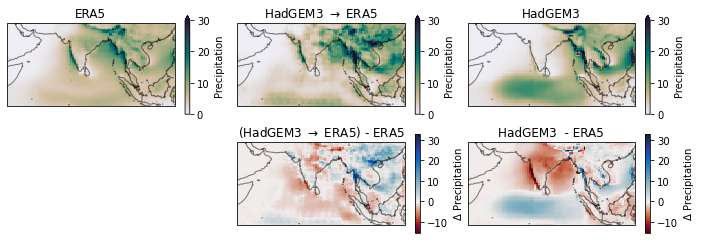

In [304]:
land_mask = False



plt.figure(figsize=(12,4))

axes = [plt.subplot(231+i, projection=ccrs.PlateCarree()) for i in [0,1,2,4,5]]
titles = ["ERA5", 
          f"HadGEM3 " + r"$\rightarrow$ " + f"ERA5", 
          "HadGEM3", 
          f"(HadGEM3 "  + r"$\rightarrow$ " + f"ERA5) - ERA5",
          f"HadGEM3  - ERA5",]
          
datasets = results+[r-results[0] for r in results[1:]]


abs_range = 0, 30# range_multi(results)
dif_range = range_multi(datasets[-2:])


vmins = [abs_range[0]]*3+[dif_range[0]]*2#[-max(np.abs(dif_range))]*2
vmaxs = [abs_range[1]]*3+[dif_range[1]]*2#[max(np.abs(dif_range))]*2
cmaps=[cmocean.cm.rain]*3+[cmocean.cm.balance_r]*2
norms = [None]*3 + [colors.TwoSlopeNorm(vmin=vmins[-1], vmax=vmaxs[-1], vcenter=0)]*2

i=0
for da, ax, title, vmin, vmax, norm, cmap in zip(datasets, axes, titles, vmins, vmaxs, norms, cmaps):
    
    cbar_kwargs = dict(label=f"Precipitation" if i<3 else f"$\Delta$ Precipitation")
    if land_mask:
        da.where(get_land_mask(da)[0]).plot(ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, norm=norm, cbar_kwargs=cbar_kwargs)
    else:
        da.plot(ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, norm=norm, cbar_kwargs=cbar_kwargs)
    ax.coastlines(alpha=0.5)
    ax.set_title(title)
    ax.set_xlim(*lon_range)
    ax.set_ylim(*lat_range)
    i+=1
    
    
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)
plt.show()

In [131]:
results = []
with ProgressBar(dt=10):
    for ds in [ds_target, ds_base, ds_trans]:
        results.append(select_months(ds.pr.isel(run=0).clip(0,None)**0.25, [6, 7, 8, 9], drop=True).mean(dim='time').compute())

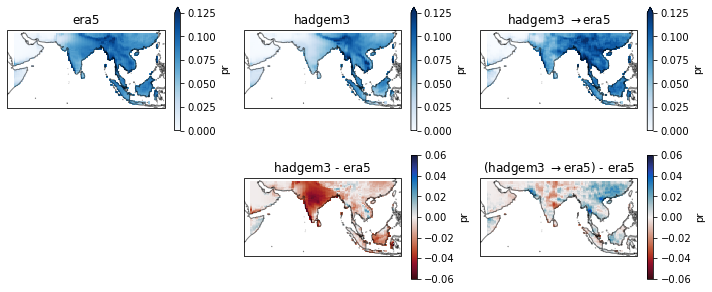

In [134]:
land_mask = True


plt.figure(figsize=(12,5))

axes = [plt.subplot(231+i, projection=ccrs.PlateCarree()) for i in [0,1,2,4,5]]
titles = [model, other_model, 
          f"{other_model} " + r"$\rightarrow$" + f"{model}", 
          f"{other_model} - {model}",
          f"({other_model} " + r"$\rightarrow$" + f"{model}) - {model}"]
datasets = results+[r-results[0] for r in results[1:]]

vdiff_abs = 0.06
vabs_max = 0.125

vmins = [0]*3+[-vdiff_abs]*2
vmaxs = [vabs_max]*3+[vdiff_abs]*2
cmaps=['Blues']*3+[cmocean.cm.balance_r]*2

for da, ax, title, vmin, vmax, cmap in zip(datasets, axes, titles, vmins, vmaxs, cmaps):
    if land_mask:
        da.where(get_land_mask(da)[0]).plot(ax=ax, vmin=vmin, vmax=vmax, cmap=cmap)
    else:
        da.plot(ax=ax, vmin=vmin, vmax=vmax, cmap=cmap)
    ax.coastlines(alpha=0.5)
    ax.set_title(title)
plt.show()

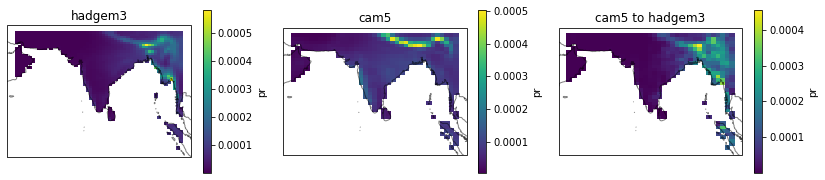

In [52]:
land_mask = True

plt.figure(figsize=(14,3))
axes = [plt.subplot(131+i, projection=ccrs.PlateCarree()) for i in range(3)]
titles = [model, other_model, f"{other_model} to {model}"]
for da, ax, title in zip(results, axes, titles):
    if land_mask:
        da.where(get_land_mask(da)[0]).plot(ax=ax)
    else:
        da.plot(ax=ax)
    ax.coastlines(alpha=0.5)
    ax.set_title(title)
plt.show()

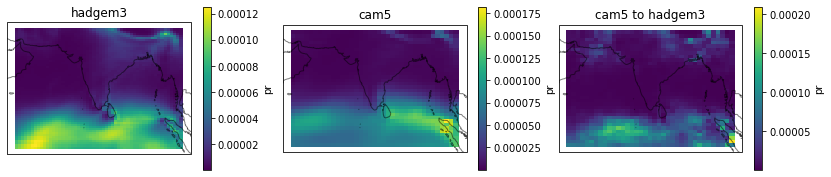

In [43]:
# this was Jan only
plt.figure(figsize=(14,3))
axes = [plt.subplot(131+i, projection=ccrs.PlateCarree()) for i in range(3)]
titles = [model, other_model, f"{other_model} to {model}"]
for da, ax, title in zip(results, axes, titles):
    da.plot(ax=ax)
    ax.coastlines(alpha=0.5)
    ax.set_title(title)
plt.show()

In [58]:
import cartopy.crs as ccrs
from skimage.metrics import structural_similarity as ssim



def calc_range(das):
    vmin, vmax = common_min_max(das)
    return (vmax - vmin).values

def add_ssim_mae(x1, x2, ax, data_range=None):
    s = ssim(x1, x2, data_range=data_range)
    mae = np.abs(x1 - x2).mean()
    ax.text(0.5, -0.1, 
            f'SSIM: {s:.3f} | MAE: {mae:.3f}', 
            ha='center', 
            va='center', 
            transform=ax.transAxes)

def plot_row(events_das, axes, form):
    vmin, vmax = common_min_max(events_das)
    if form=='relative':
        vmax = max([-vmin, vmax])
        vmin = -vmax
    data_range = calc_range(events_das)
    for e_da, ax in zip(events_das, axes):
        e_da.plot(ax=ax, vmin=vmin, vmax=vmax, cmap='RdBu_r')
        add_ssim_mae(e_da.values, events_das[0].values, ax, data_range=data_range)

def compare_events(event_target, event_trans, event_base, target_model=None, form='relative'):
    plt.figure(figsize=(12, 8))
    axes = [plt.subplot(331+i, projection=ccrs.PlateCarree()) for i in range(9)]
    events = [e.sel(form=form) for e in [event_target, event_trans, event_base]]
    
    plot_row([e.tas for e in events], axes[0:3], form)
    plot_row([e.z500 for e in events], axes[3:6], form)
    plot_row([e.pr for e in events], axes[6:9], form) 
    
    if target_model is None:
        titles = ['target', 'translation', 'base']
    else:
        other_model = ({'era5','hadgem3'} - {target_model}).pop()
        titles = [target_model, f"{other_model} to {target_model}", other_model]
    for ax, title in zip(axes[:3], titles):
        ax.set_title(title)
    for ax in axes[3:]:
        ax.set_title('')
    for ax in axes: ax.coastlines(alpha=0.5)

> Following Hsu et al.[2011], the NHSM region encloses grid boxes for which the mean annual range (difference between the May–September and November–March averages) in precipitation for all years exceeds 2 mm d$^{−1}$ and the mean May–September precipitation exceeds 55% of the annual total. Grid boxes are excluded if they are north of the subtropics (40◦N) or isolated. The region is fixed for all years; therefore, any spatial shift of the monsoon is not captured. However, changes in precipitation due to possible variations inthe monsoon area should be small compared to the total precipitation in the whole region. Figure 2 shows that the NHSM region does not change by much over the observation period, with only a few grid boxes that meet the criteria in at least 1 year excluded from the final NHSM mask. An alternative method would allow the region to change year by year, but this could result in the region changing size, making it difficult to distinguish changes in precipitation rate from changes due to the NHSM region shrinking or growing overtime. The NHSM region is defined for each observational data set, and the model data are masked to match the spatial and temporal coverage of each
> 
> -- https://agupubs.onlinelibrary.wiley.com/doi/10.1002/2014GL060811

In [ ]:
ds_target.pr.load()
ds_base.pr.load()
ds_trans.pr.load()
ds_trans_reverse.pr.load()
ds_qm.pr.load()
ds_qm_reverse.pr.load()

In [59]:
# get mask from era5 dataset
for da in [ds_target.pr]:
    da = da.where(get_land_mask(da)[0].numpy().astype(bool)).where(da.lat<=40)
    may_sept_pr = select_months(da.isel(run=0).clip(0,None), [5,6,7,8,9], drop=True).mean(dim='time')
    nov_mar_pr = select_months(da.isel(run=0).clip(0,None), [11,12,1,2,3], drop=True).mean(dim='time')
    yearly_pr = da.isel(run=0).clip(0,None).groupby(da.time.dt.year).sum(dim='time').mean(dim='year')
    monsoon_season_pr = select_months(da.isel(run=0).clip(0,None), [5,6,7,8,9], drop=True)
    monsoon_season_pr = monsoon_season_pr.groupby(monsoon_season_pr.time.dt.year).sum(dim='time').mean(dim='year')
    pr_diff_2 = (may_sept_pr - nov_mar_pr)>2
    pr_055 = monsoon_season_pr > 0.55*yearly_pr
    is_monsoon_gridpoint = xr.ufuncs.logical_and(
        pr_055,
        pr_diff_2
    )

/anaconda/envs/py37_pytorch2/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


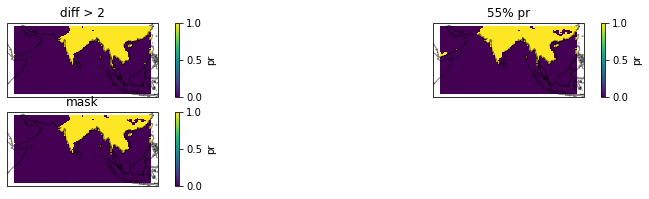

In [60]:

land_mask = True

plt.figure(figsize=(14,3))
for da, title, ax in zip(
    [pr_diff_2, pr_055, is_monsoon_gridpoint],
    ['diff > 2', '55% pr', 'mask'],
    [plt.subplot(221+i, projection=ccrs.PlateCarree()) for i in range(3)]
):
    da.plot(ax=ax)
    ax.coastlines(alpha=0.5)
    ax.set_title(title)
plt.show()


In [82]:
select_months(ds_base.pr.isel(run=0).clip(0,None), [11,12,1,2,3], drop=True).resample(time='1M', loffset='15D').mean()

<xarray.DataArray 'pr' (time: 420, lat: 68, lon: 92)>
array([[[6.71701908e+00, 7.79209471e+00, 9.48971081e+00, ...,
         9.24917412e+00, 7.79524374e+00, 8.75776291e+00],
        [5.74590826e+00, 7.45676565e+00, 9.54552841e+00, ...,
         1.26193399e+01, 1.18355465e+01, 1.03959141e+01],
        [4.46604919e+00, 6.80419588e+00, 8.54671764e+00, ...,
         1.70578403e+01, 1.13497992e+01, 6.44628286e+00],
        ...,
        [1.08538056e-02, 1.65169742e-02, 1.22792404e-02, ...,
         2.25591159e+00, 1.80331457e+00, 1.81068122e+00],
        [1.62720811e-02, 2.45386772e-02, 1.68461073e-02, ...,
         2.97067666e+00, 1.78911185e+00, 1.74504554e+00],
        [1.84595902e-02, 2.43397430e-02, 1.05823157e-02, ...,
         3.85202384e+00, 2.90901470e+00, 2.38694692e+00]],

       [[4.02122879e+00, 5.17352343e+00, 6.17935371e+00, ...,
         1.14163771e+01, 1.25410032e+01, 1.36605225e+01],
        [3.42439866e+00, 5.10311651e+00, 6.05564642e+00, ...,
         1.26836395e+01, 1.39390526e+01, 1.28415499e+01],
        [2.60933566e+00, 3.50380325e+00, 3.76894236e+00, ...,
         1.66040077e+01, 1.17937450e+01, 6.40244532e+00],
...
        [4.51755971e-01, 3.30279350e-01, 1.08254053e-01, ...,
         4.54502296e+00, 4.36265230e+00, 5.22795057e+00],
        [1.96843773e-01, 1.63127467e-01, 8.32360089e-02, ...,
         4.87347317e+00, 5.82927847e+00, 5.18575764e+00],
        [7.28127137e-02, 7.23294243e-02, 6.72879219e-02, ...,
         1.51828372e+00, 2.27930427e+00, 3.44591379e+00]],

       [[4.51700354e+00, 5.64938402e+00, 6.47402048e+00, ...,
         2.69857621e+00, 2.60683703e+00, 2.30295229e+00],
        [4.02692890e+00, 5.48668337e+00, 5.92417192e+00, ...,
         2.59918690e+00, 2.24386287e+00, 1.44000781e+00],
        [3.32299662e+00, 4.42215443e+00, 5.93853951e+00, ...,
         3.43325853e+00, 2.13876200e+00, 1.32102859e+00],
        ...,
        [6.90395012e-02, 5.51492758e-02, 6.17912300e-02, ...,
         4.07505691e-01, 5.72086513e-01, 8.30038130e-01],
        [1.74544156e-01, 1.87752306e-01, 2.54949629e-01, ...,
         4.72278804e-01, 5.80036759e-01, 7.06083775e-01],
        [3.37351412e-01, 3.57700616e-01, 6.09061599e-01, ...,
         7.16143250e-01, 7.27183878e-01, 7.55111098e-01]]], dtype=float32)
Coordinates:
  * time     (time) object 1979-02-15 00:00:00 ... 2014-01-15 00:00:00
    run      int64 1
  * lon      (lon) float32 44.583332 45.416664 46.25 ... 119.58333 120.416664
  * lat      (lat) float32 -7.499997 -6.9444413 ... 29.166672 29.722227

In [92]:
ds_base.time

<xarray.DataArray 'time' (time: 12599)>
array([cftime.Datetime360Day(1979, 1, 1, 12, 0, 0, 0),
       cftime.Datetime360Day(1979, 1, 2, 12, 0, 0, 0),
       cftime.Datetime360Day(1979, 1, 3, 12, 0, 0, 0), ...,
       cftime.Datetime360Day(2013, 12, 27, 12, 0, 0, 0),
       cftime.Datetime360Day(2013, 12, 28, 12, 0, 0, 0),
       cftime.Datetime360Day(2013, 12, 29, 12, 0, 0, 0)], dtype=object)
Coordinates:
  * time     (time) object 1979-01-01 12:00:00 ... 2013-12-29 12:00:00
Attributes:
    axis:           T
    bounds:         time_bnds
    long_name:      time
    standard_name:  time

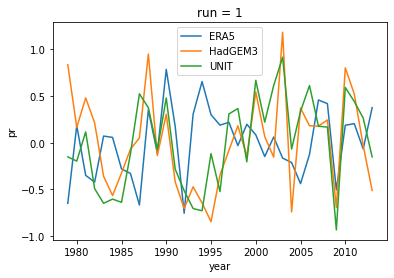

In [103]:
for da, label in zip(
    [ds_target.pr, ds_base.pr, ds_trans.pr, ds_qm.pr],
    ['ERA5', 'HadGEM3', 'UNIT', 'QM']
    
):
    da = select_months(da.isel(run=0).clip(0,None), [5,6,7,8,9], drop=True)
    da = da.groupby(da.time.dt.year).mean()
    da = da.where(is_monsoon_gridpoint).mean(dim=('lat', 'lon'))
    da = da - da.mean()
    if label=='QM': break
    da.plot(label=label)
plt.legend()
plt.show()


Looks like there is no signal to be able to capture anyway